# Show Amazon Data

In [1]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("data/amazon_hours.csv") 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

x = data.loc[:, 'DATE']
y = data.loc[:, 'WEIGHTED AV. PRICE']

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

data.shape

(26208, 17)

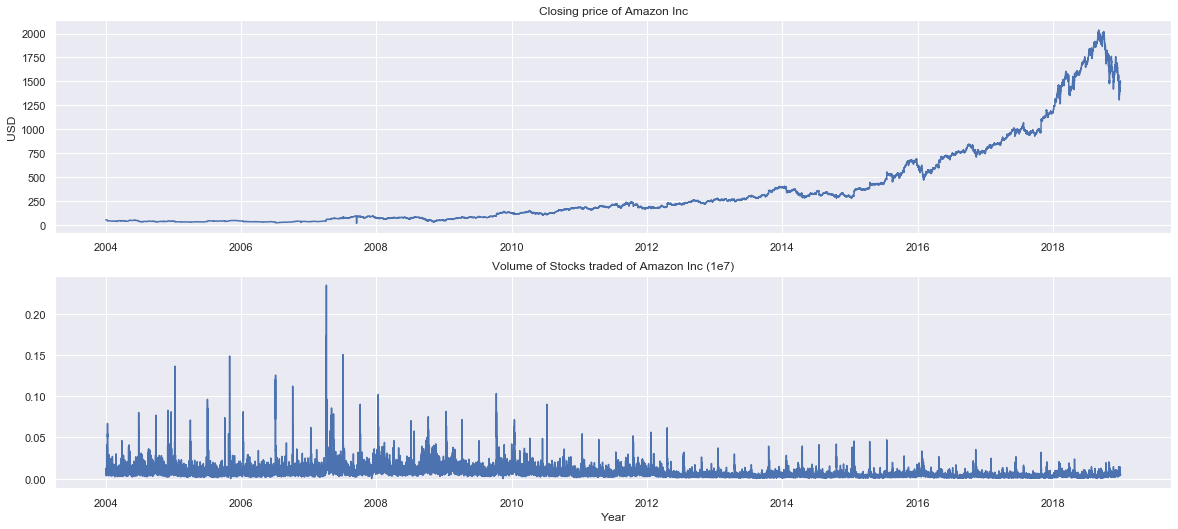

In [14]:
fig,ax=plt.subplots(2,1,figsize=(20,5))

plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1.4, wspace=None, hspace=None)

date = np.linspace(2004, 2019, num = 26208)

ax[0].plot(date, data['CLOSE'])
ax[0].set_title('Closing price of Amazon Inc')
ax[0].set_ylabel("USD")

ax[1].plot(date, data['VOLUME']/1000000)
ax[1].set_title('Volume of Stocks traded of Amazon Inc (1e7)')
ax[1].set_xlabel("Year")

plt.show()
 

In [2]:
import datetime as dt

class Timer():

	def __init__(self):
		self.start_dt = None

	def start(self):
		self.start_dt = dt.datetime.now()

	def stop(self):
		end_dt = dt.datetime.now()
		print('Time taken: %s' % (end_dt - self.start_dt))

import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import math
from sklearn.metrics import mean_absolute_error


class Model():
	"""A class for an building and inferencing an lstm model"""

	def __init__(self):
		self.model = Sequential()

	def load_model(self, filepath):
		print('[Model] Loading model from file %s' % filepath)
		self.model = load_model(filepath)

	def build_model(self, configs):
		timer = Timer()
		timer.start()

		for layer in configs['model']['layers']:
			neurons = layer['neurons'] if 'neurons' in layer else None
			dropout_rate = layer['rate'] if 'rate' in layer else None
			activation = layer['activation'] if 'activation' in layer else None
			return_seq = layer['return_seq'] if 'return_seq' in layer else None
			input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
			input_dim = layer['input_dim'] if 'input_dim' in layer else None

			if layer['type'] == 'dense':
				self.model.add(Dense(neurons, activation=activation))
			if layer['type'] == 'lstm':
				self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
			if layer['type'] == 'dropout':
				self.model.add(Dropout(dropout_rate))

		self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

		print('[Model] Model Compiled')
		timer.stop()

	def train(self, x, y, epochs, batch_size, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			EarlyStopping(monitor='val_loss', patience=2),
			ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
		]
		self.model.fit(
			x,
			y,
			epochs=epochs,
			batch_size=batch_size,
			callbacks=callbacks
		)
		self.model.save(save_fname)

		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
		self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1
		)
		
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
		print('[Model] Predicting Point-by-Point...')
		predicted = self.model.predict(data)
		predicted = np.reshape(predicted, (predicted.size,))
		return predicted

	def predict_sequences_multiple(self, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

	def predict_sequence_full(self, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		print('[Model] Predicting Sequences Full...')
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted
    
import math
import numpy as np
import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []

        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])  # move windows

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0

        while i < (self.len_train - seq_len):

            x_batch = []
            y_batch = []

            for b in range(batch_size):

                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0

                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1

            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''

        window = self.data_train[i:i+seq_len]



        window = self.normalise_windows(window, single_window=True)[0] if normalise else window

    #    print("x.shape = " + str(window.shape))

        x = window[:-1]  # 除了最後一個元素的slice

    #    print("x.shape = " + str(x.shape))

        y = window[-1, [0]]

   #     print("y.shape = " + str(y.shape))

        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data

        for window in window_data:

            normalised_window = []

            for col_i in range(window.shape[1]):

                a = float(window[0, col_i])

            #     print("window[0, col_i] = " + str(a))

                if( a == 0):
                    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                    a = 20000

                normalised_col = [  (   (   float(p) / a   ) - 1  ) for p in window[:, col_i]]

                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)    

__author__ = "Jakob Aungiers"
__copyright__ = "Jakob Aungiers 2018"
__version__ = "2.0.0"
__license__ = "MIT"

import os
import json
import time
import math
import matplotlib.pyplot as plt
 


def plot_results(predicted_data, true_data):

    fig = plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)

#    ax.plot(true_data, '-s', label='True Data')
#    plt.plot(predicted_data, '-o', label='Prediction')
 
    ax.plot(true_data,  label='True Data')
    plt.plot(predicted_data,  label='Prediction')
    
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):

        padding = [None for p in range(i * prediction_len)]

        NoneType = type(None)

        if(isinstance(padding, NoneType)):
            padding = 0

        plt.plot(padding + data, label='Prediction')
        # plt.legend()
        
    plt.show()

configs = json.load(open('config.json', 'r'))

if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

model = Model()
model.build_model(configs)
x, y = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
) 


def let_us_LSTM_Multiple(epochs_, batch_size_, normalise_, sequence_length_):
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - sequence_length_) / batch_size_)
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=sequence_length_,
            batch_size=batch_size_,
            normalise=normalise_
        ),
        epochs=epochs_,
        batch_size=batch_size_,
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=sequence_length_,
        normalise=normalise_
    )

    predictions = model.predict_sequences_multiple(x_test, sequence_length_, sequence_length_)
    plot_results_multiple(predictions, y_test, sequence_length_)
    
    
def let_us_LSTM(epochs_, batch_size_, normalise_, sequence_length_):
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - sequence_length_) / batch_size_)
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=sequence_length_,
            batch_size=batch_size_,
            normalise=normalise_
        ),
        epochs=epochs_,
        batch_size=batch_size_,
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=sequence_length_,
        normalise=normalise_
    )

    
    predictions = model.predict_point_by_point(x_test)
    ########################################################################
    from sklearn.metrics import mean_squared_error
    loss_final = mean_squared_error(predictions, y_test)
    print("Testing Loss = " + str(loss_final))
    ########################################################################
    plot_results(predictions, y_test)
    
    
    print(predictions.shape)
    print(y_test.shape)

    m = pd.DataFrame(predictions)
    n = pd.DataFrame(y_test)

    m.to_csv("predictions.csv")
    n.to_csv("y_test.csv")

    p = 0
    t = 0

    t_1 = 0

    count = 0

    for a in range(len(predictions)):

        if(a==0):
            t_1 = y_test[a]
            continue
 
        p = predictions[a]
        t = y_test[a]

        match = (t - t_1)*(p - t_1)

        if(match > 0):
            count += 1

        t_1 = t
        
    print("UP or DOWN accuracy  = " + str( count/len(predictions) ) )
    print("RMSE  = " + str(math.sqrt(mean_squared_error(y_test, predictions))))
    print("MAE = " + str(mean_absolute_error(y_test, predictions) ))
    print("MSE  = " +  str(mean_squared_error(y_test, predictions)))

    
    def get_mape(y_true, y_pred):
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true))

    print("MAPE  = " +  str(get_mape(y_test, predictions)))
    
    
    

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

[Model] Model Compiled
Time taken: 0:00:01.275729


In [ ]:
let_us_LSTM(2, 50, True, 50) # Amazon, 0.8

[Model] Training Started
[Model] 2 epochs, 50 batch size, 425 batches per epoch

Epoch 1/2
264/425 [=================>............] - ETA: 2:03 - loss: 0.0015

[Model] Training Started
[Model] 5 epochs, 50 batch size, 425 batches per epoch

Epoch 1/5
425/425 [==============================] - 109s 257ms/step - loss: 8.7190e-04
Epoch 2/5
425/425 [==============================] - 121s 284ms/step - loss: 4.8346e-04
Epoch 3/5
425/425 [==============================] - 106s 250ms/step - loss: 3.3207e-04
Epoch 4/5
425/425 [==============================] - 71s 168ms/step - loss: 2.2066e-04
Epoch 5/5
425/425 [==============================] - 74s 175ms/step - loss: 1.9295e-04
[Model] Training Completed. Model saved as saved_models/06122019-222042-e5.h5
Time taken: 0:08:05.502594
[Model] Predicting Point-by-Point...
Testing Loss = 4.7266238460738295e-05


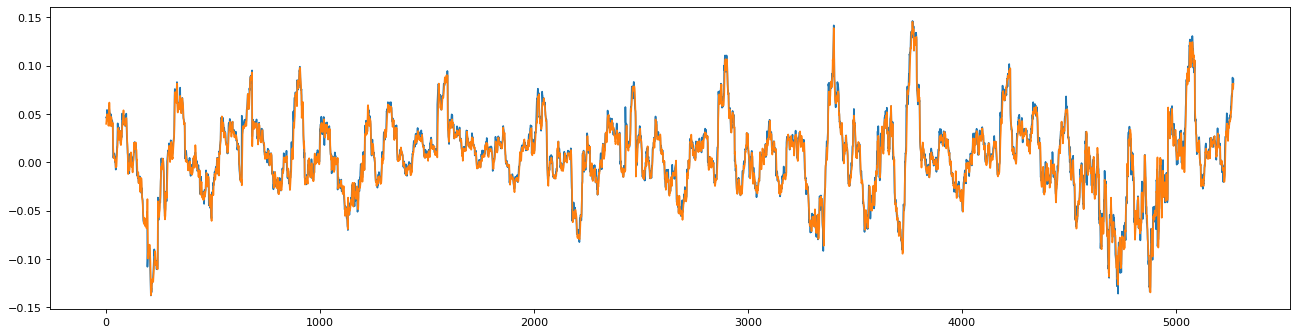

(5270,)
(5270, 1)
UP or DOWN accuracy  = 0.6345351043643264
RMSE  = 0.006875044615181657
MAE = 0.004512512957983424
MSE  = 4.7266238460738295e-05
MAPE  = 8.268605152980617


In [3]:
let_us_LSTM(5, 50, True, 50) # Amazon, 0.8

In [5]:
let_us_LSTM(10, 50, True, 50) # Amazon, 0.8

[Model] Training Started
[Model] 10 epochs, 50 batch size, 425 batches per epoch
Epoch 1/10
214/425 [==============>...............] - ETA: 1:46 - loss: 2.6480e-04

KeyboardInterrupt: 

[Model] Training Started
[Model] 20 epochs, 50 batch size, 529 batches per epoch
Epoch 1/20
529/529 [==============================] - 102s 192ms/step - loss: 0.0017
Epoch 2/20
529/529 [==============================] - 88s 166ms/step - loss: 7.2448e-04
Epoch 3/20
529/529 [==============================] - 86s 163ms/step - loss: 4.2672e-04
Epoch 4/20
529/529 [==============================] - 87s 165ms/step - loss: 2.4536e-04
Epoch 5/20
529/529 [==============================] - 87s 165ms/step - loss: 2.0203e-04
Epoch 6/20
529/529 [==============================] - 89s 169ms/step - loss: 2.1769e-04
Epoch 7/20
529/529 [==============================] - 94s 177ms/step - loss: 1.6844e-04
Epoch 8/20
529/529 [==============================] - 93s 175ms/step - loss: 1.4681e-04
Epoch 9/20
529/529 [==============================] - 92s 174ms/step - loss: 2.2671e-04
Epoch 10/20
529/529 [==============================] - 94s 177ms/step - loss: 1.4393e-04
Epoch 11/20
529/529 [====================

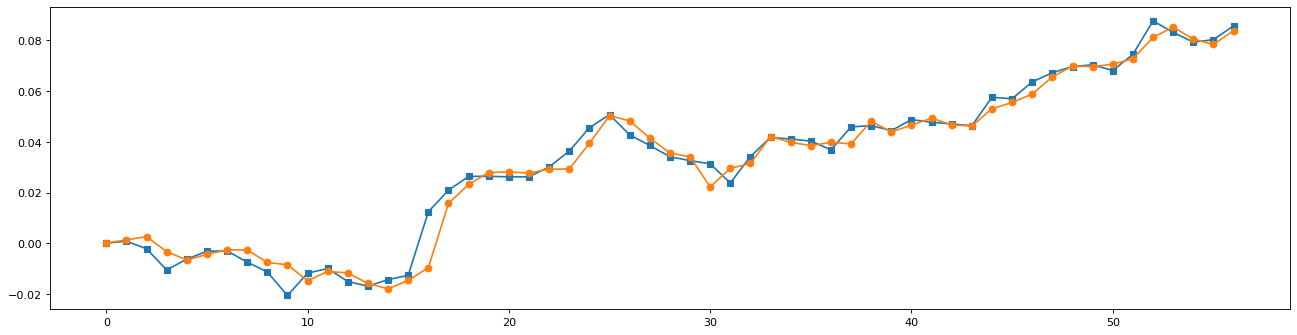

In [55]:
let_us_LSTM(20, 50, True, 50)  # Training Testing Split at 0.996

[Model] Training Started
[Model] 2 epochs, 50 batch size, 425 batches per epoch
Epoch 1/2
425/425 [==============================] - 81s 190ms/step - loss: 0.0017
Epoch 2/2
425/425 [==============================] - 71s 167ms/step - loss: 7.2168e-04
[Model] Training Completed. Model saved as saved_models/06122019-193945-e2.h5
Time taken: 0:02:38.023098
[Model] Predicting Point-by-Point...
Testing Loss = 0.00019656055980009018


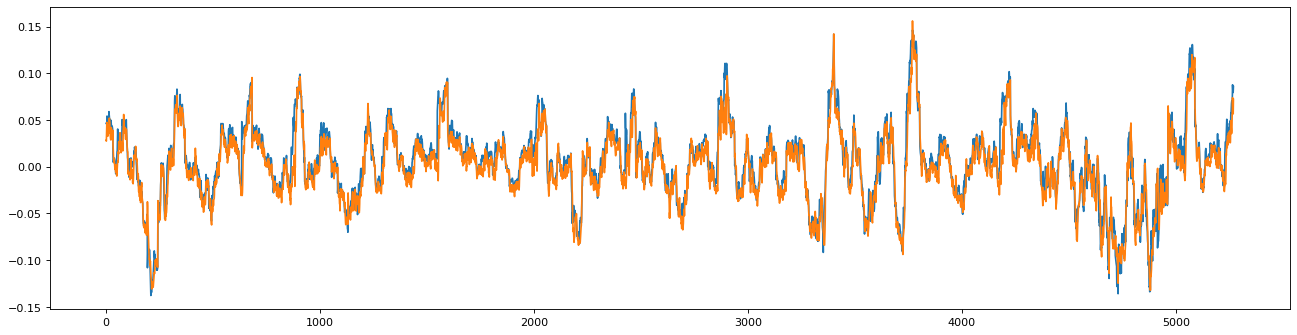

(5270,)
(5270, 1)
UP or DOWN accuracy  = 0.5698292220113852
RMSE  = 0.014020005699003484
MAE = 0.009878519331489817
MSE  = 0.00019656055980009018
MAPE  = 787.3196745963141


In [18]:
let_us_LSTM(2, 50, True, 50)  # Training Testing Split at 0.8  # Final test stage!!!!!!!!!

[Model] Training Started
[Model] 6 epochs, 100 batch size, 213 batches per epoch
Epoch 1/6
213/213 [==============================] - 70s 329ms/step - loss: 3.5297e-04
Epoch 2/6
213/213 [==============================] - 73s 341ms/step - loss: 3.0725e-04
Epoch 3/6
213/213 [==============================] - 83s 392ms/step - loss: 2.7213e-04
Epoch 4/6
213/213 [==============================] - 86s 405ms/step - loss: 2.9205e-04
Epoch 5/6
213/213 [==============================] - 72s 339ms/step - loss: 2.2625e-04
Epoch 6/6
213/213 [==============================] - 78s 365ms/step - loss: 2.0858e-04
[Model] Training Completed. Model saved as saved_models/06122019-194231-e6.h5
Time taken: 0:07:42.803156
[Model] Predicting Point-by-Point...
Testing Loss = 5.8926224803349124e-05


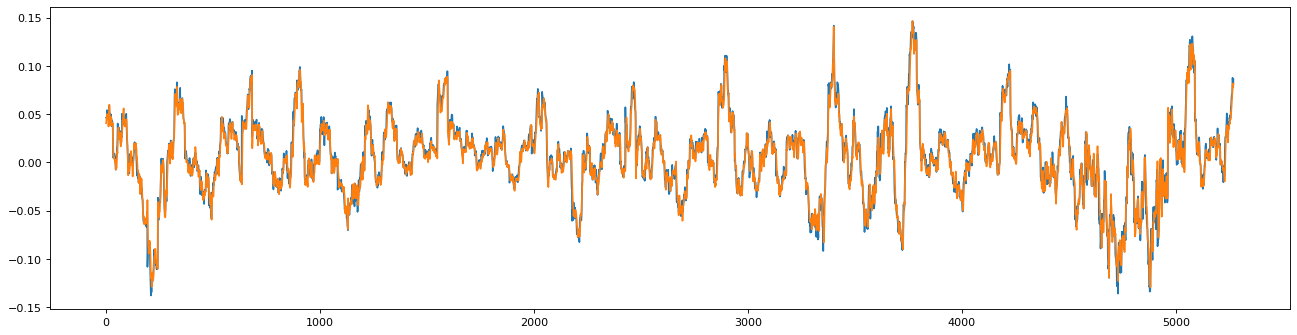

(5270,)
(5270, 1)
UP or DOWN accuracy  = 0.6178368121442125
RMSE  = 0.00767634188942553
MAE = 0.005136008730722161
MSE  = 5.8926224803349124e-05
MAPE  = 808.7086558222296


In [19]:
let_us_LSTM(6, 100, True, 50)  # Training Testing Split at 0.8  # Final test stage!!!!!!!!!

[Model] Training Started
[Model] 2 epochs, 100 batch size, 213 batches per epoch
Epoch 1/2
213/213 [==============================] - 68s 321ms/step - loss: 0.0013
Epoch 2/2
213/213 [==============================] - 68s 321ms/step - loss: 5.8859e-04
[Model] Training Completed. Model saved as saved_models/06122019-210612-e2.h5
Time taken: 0:02:22.773725
[Model] Predicting Point-by-Point...
Testing Loss = 0.00013026435727891603


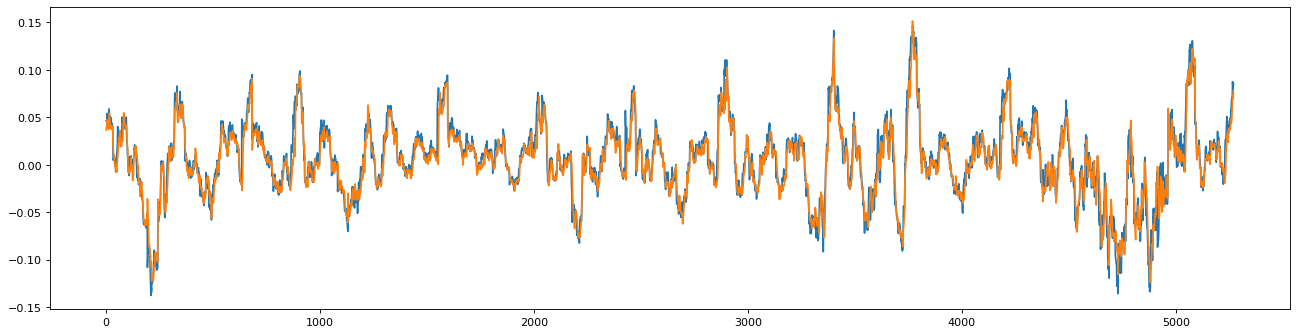

(5270,)
(5270, 1)
UP or DOWN accuracy  = 0.577988614800759
RMSE  = 0.011413341196990303
MAE = 0.007792371215603666
MSE  = 0.00013026435727891603
MAPE  = 7.711333563830869


In [23]:
let_us_LSTM(2, 100, True, 50)  # Training Testing Split at 0.8 | Apple Data

In [ ]:
let_us_LSTM(10, 100, True, 50)  # Training Testing Split at 0.8 | Apple Data

[Model] Training Started
[Model] 10 epochs, 25 batch size, 1058 batches per epoch
Epoch 1/10
1058/1058 [==============================] - 120s 114ms/step - loss: 9.6189e-05
Epoch 2/10
1058/1058 [==============================] - 119s 113ms/step - loss: 8.6538e-05
Epoch 3/10
1058/1058 [==============================] - 121s 115ms/step - loss: 1.1459e-04
Epoch 4/10
1058/1058 [==============================] - 120s 114ms/step - loss: 8.4365e-05
Epoch 5/10
1058/1058 [==============================] - 121s 115ms/step - loss: 8.3550e-05
Epoch 6/10
1058/1058 [==============================] - 123s 116ms/step - loss: 9.7009e-05
Epoch 7/10
1058/1058 [==============================] - 123s 116ms/step - loss: 1.1501e-04
Epoch 8/10
1058/1058 [==============================] - 122s 115ms/step - loss: 9.2228e-05
Epoch 9/10
1058/1058 [==============================] - 121s 114ms/step - loss: 7.8466e-05
Epoch 10/10
1058/1058 [==============================] - 120s 113ms/step - loss: 9.7592e-05
[Model]

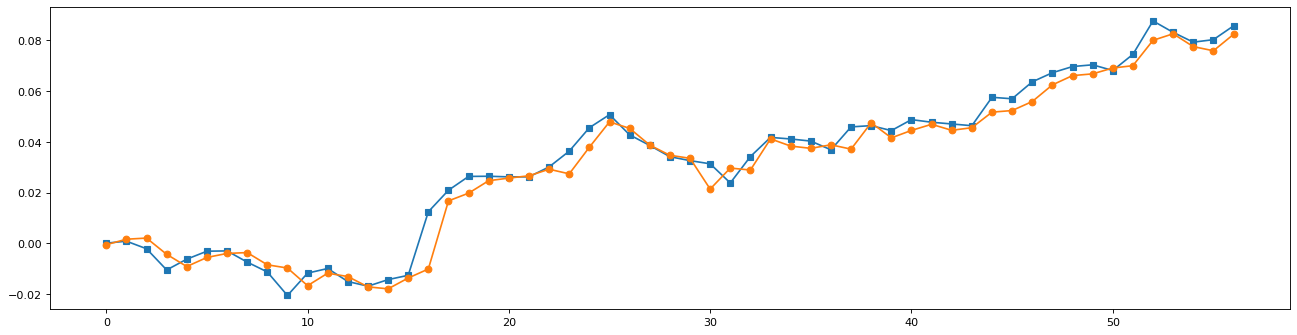

In [60]:
let_us_LSTM(10, 25, True, 50)  # Training Testing Split at 0.996

[Model] Training Started
[Model] 5 epochs, 50 batch size, 516 batches per epoch
Epoch 1/5
516/516 [==============================] - 192s 372ms/step - loss: 1.4387e-04
Epoch 2/5
516/516 [==============================] - 222s 430ms/step - loss: 2.0211e-04
Epoch 3/5
516/516 [==============================] - 1306s 3s/step - loss: 1.3500e-04
Epoch 4/5
516/516 [==============================] - 89s 172ms/step - loss: 1.1755e-04
Epoch 5/5
516/516 [==============================] - 85s 164ms/step - loss: 1.4435e-04
[Model] Training Completed. Model saved as saved_models/01122019-182647-e5.h5
Time taken: 0:31:33.086387
[Model] Predicting Point-by-Point...
Testing Loss = 6.885066534947297e-05


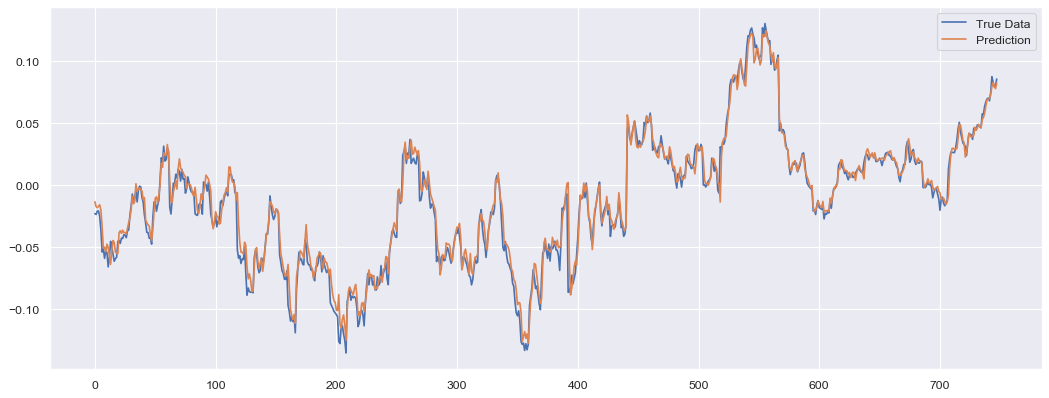

In [73]:
let_us_LSTM(5, 50, True, 50)

[Model] Training Started
[Model] 7 epochs, 50 batch size, 516 batches per epoch
Epoch 1/7
516/516 [==============================] - 85s 164ms/step - loss: 1.1315e-04
Epoch 2/7
516/516 [==============================] - 85s 164ms/step - loss: 1.0466e-04
Epoch 3/7
516/516 [==============================] - 85s 165ms/step - loss: 1.3458e-04
Epoch 4/7
516/516 [==============================] - 84s 163ms/step - loss: 1.1705e-04
Epoch 5/7
516/516 [==============================] - 85s 164ms/step - loss: 1.0761e-04
Epoch 6/7
516/516 [==============================] - 85s 164ms/step - loss: 9.0724e-05
Epoch 7/7
516/516 [==============================] - 84s 164ms/step - loss: 9.9779e-05
[Model] Training Completed. Model saved as saved_models/01122019-185821-e7.h5
Time taken: 0:09:52.137345
[Model] Predicting Point-by-Point...
Testing Loss = 5.576263323427229e-05


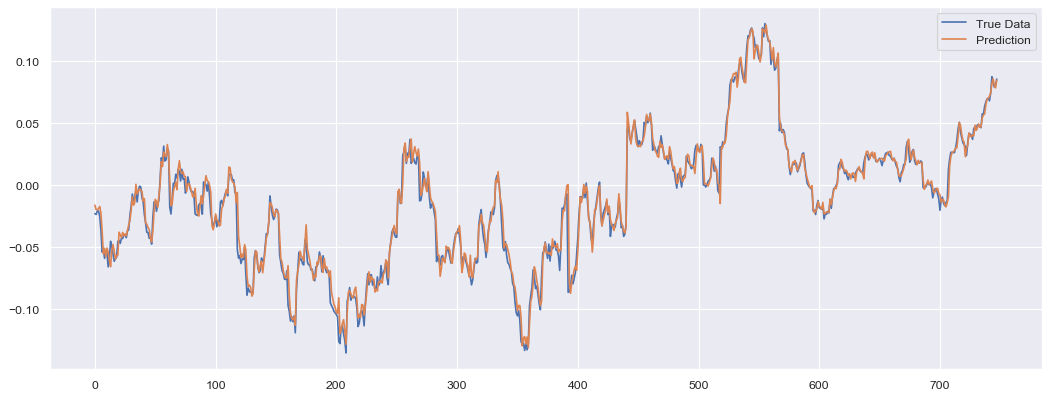

In [74]:
let_us_LSTM(7, 50, True, 50)

[Model] Training Started
[Model] 10 epochs, 50 batch size, 516 batches per epoch
Epoch 1/10
516/516 [==============================] - 85s 165ms/step - loss: 1.7105e-04
Epoch 2/10
516/516 [==============================] - 85s 165ms/step - loss: 1.0185e-04
Epoch 3/10
516/516 [==============================] - 101s 195ms/step - loss: 8.3842e-05
Epoch 4/10
516/516 [==============================] - 114s 221ms/step - loss: 9.7151e-05
Epoch 5/10
516/516 [==============================] - 115s 222ms/step - loss: 8.9492e-05
Epoch 6/10
516/516 [==============================] - 106s 206ms/step - loss: 1.0500e-04
Epoch 7/10
516/516 [==============================] - 91s 176ms/step - loss: 1.0616e-04
Epoch 8/10
516/516 [==============================] - 107s 208ms/step - loss: 9.5523e-05
Epoch 9/10
516/516 [==============================] - 112s 217ms/step - loss: 8.5367e-05
Epoch 10/10
516/516 [==============================] - 115s 223ms/step - loss: 8.5057e-05
[Model] Training Completed. Mod

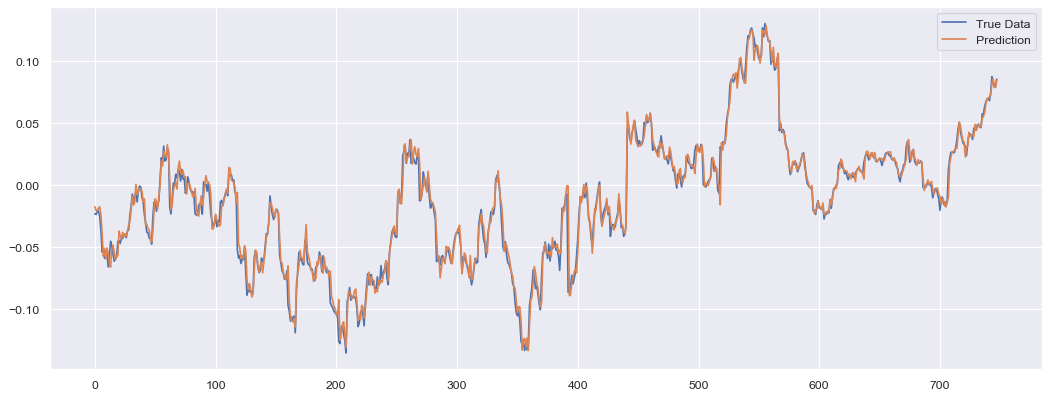

In [75]:
let_us_LSTM(10, 50, True, 50)

[Model] Training Started
[Model] 20 epochs, 50 batch size, 516 batches per epoch
Epoch 1/20
516/516 [==============================] - 113s 218ms/step - loss: 1.2554e-04
Epoch 2/20
516/516 [==============================] - 117s 226ms/step - loss: 9.5783e-05
Epoch 3/20
516/516 [==============================] - 121s 235ms/step - loss: 1.3301e-04
Epoch 4/20
516/516 [==============================] - 122s 235ms/step - loss: 8.4784e-05
Epoch 5/20
516/516 [==============================] - 98s 190ms/step - loss: 8.2199e-05
Epoch 6/20
516/516 [==============================] - 91s 177ms/step - loss: 8.9591e-05
Epoch 7/20
516/516 [==============================] - 87s 169ms/step - loss: 8.0939e-05
Epoch 8/20
516/516 [==============================] - 87s 170ms/step - loss: 8.9681e-05
Epoch 9/20
516/516 [==============================] - 87s 169ms/step - loss: 8.1776e-05
Epoch 10/20
516/516 [==============================] - 98s 190ms/step - loss: 8.5807e-05
Epoch 11/20
516/516 [=============

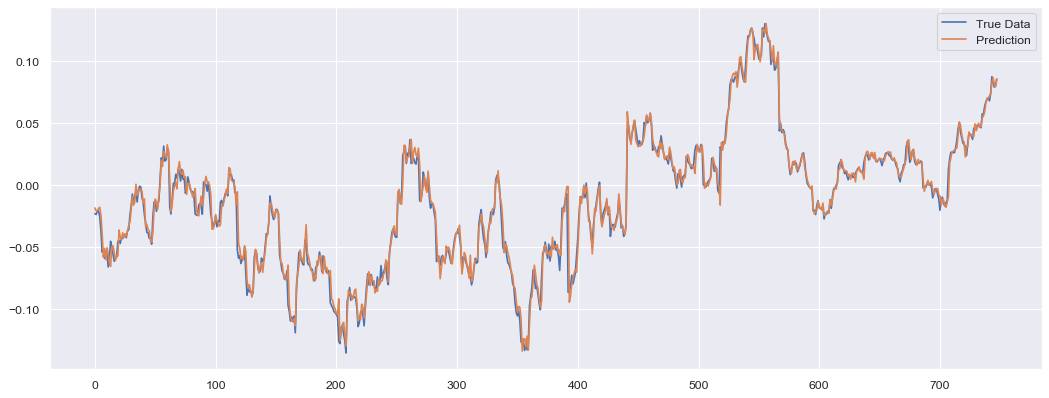

In [76]:
let_us_LSTM(20, 50, True, 50)

[Model] Training Started
[Model] 2 epochs, 50 batch size, 516 batches per epoch
Epoch 1/2
516/516 [==============================] - 91s 177ms/step - loss: 8.4128e-05
Epoch 2/2
516/516 [==============================] - 98s 190ms/step - loss: 9.3904e-05
[Model] Training Completed. Model saved as saved_models/01122019-223117-e2.h5
Time taken: 0:03:09.639804
[Model] Predicting Point-by-Point...
Testing Loss = 5.409685133041131e-05


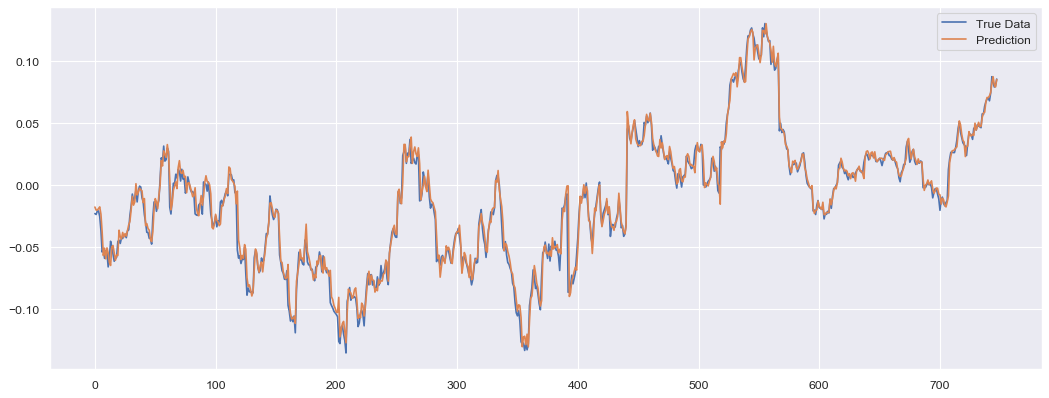

In [77]:
let_us_LSTM(2, 50, True, 50)  # 0.998 testing rate --> 80 points to test 

In [7]:
## (8, 100, True, 50)

[Model] Training Started
[Model] 8 epochs, 100 batch size, 533 batches per epoch
Epoch 1/8
533/533 [==============================] - 157s 295ms/step - loss: 3.6654e-06
Epoch 2/8
533/533 [==============================] - 157s 294ms/step - loss: 3.1680e-06
Epoch 3/8
533/533 [==============================] - 157s 295ms/step - loss: 2.6757e-06
Epoch 4/8
533/533 [==============================] - 156s 293ms/step - loss: 2.4395e-06
Epoch 5/8
533/533 [==============================] - 157s 294ms/step - loss: 2.1273e-06
Epoch 6/8
533/533 [==============================] - 160s 300ms/step - loss: 2.1452e-06
Epoch 7/8
533/533 [==============================] - 166s 312ms/step - loss: 2.0566e-06
Epoch 8/8
533/533 [==============================] - 166s 311ms/step - loss: 1.7951e-06
[Model] Training Completed. Model saved as saved_models/01122019-034946-e8.h5
Time taken: 0:21:16.831948
[Model] Predicting Sequences Multiple...


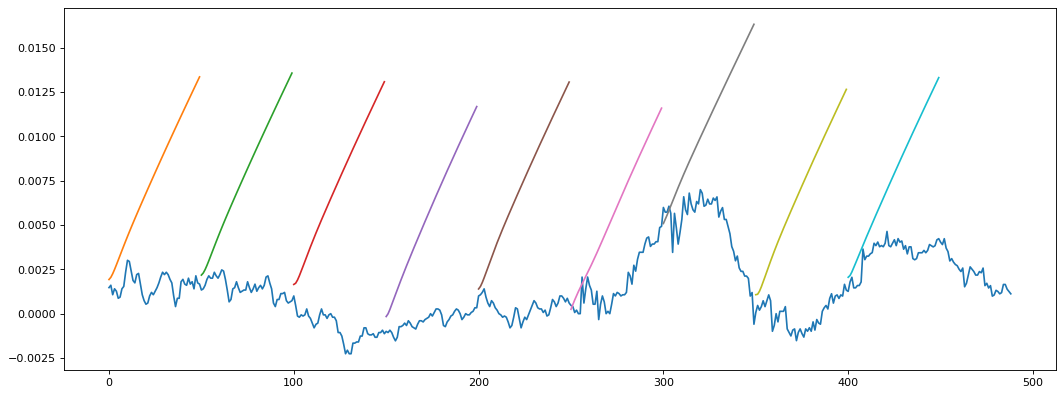

In [8]:
let_us_LSTM_Multiple(8, 100, True, 50)

[Model] Training Started
[Model] 8 epochs, 100 batch size, 533 batches per epoch
Epoch 1/8
533/533 [==============================] - 167s 314ms/step - loss: 1.6459e-06
Epoch 2/8
533/533 [==============================] - 166s 312ms/step - loss: 1.5144e-06
Epoch 3/8
533/533 [==============================] - 166s 312ms/step - loss: 1.4219e-06
Epoch 4/8
533/533 [==============================] - 167s 314ms/step - loss: 1.3040e-06
Epoch 5/8
533/533 [==============================] - 166s 312ms/step - loss: 1.3362e-06
Epoch 6/8
533/533 [==============================] - 166s 311ms/step - loss: 1.5343e-06
Epoch 7/8
533/533 [==============================] - 175s 329ms/step - loss: 1.2192e-06
Epoch 8/8
533/533 [==============================] - 168s 316ms/step - loss: 1.1838e-06
[Model] Training Completed. Model saved as saved_models/01122019-041110-e8.h5
Time taken: 0:22:22.391803
[Model] Predicting Point-by-Point...
Testing Loss = 4.550629667630675e-07


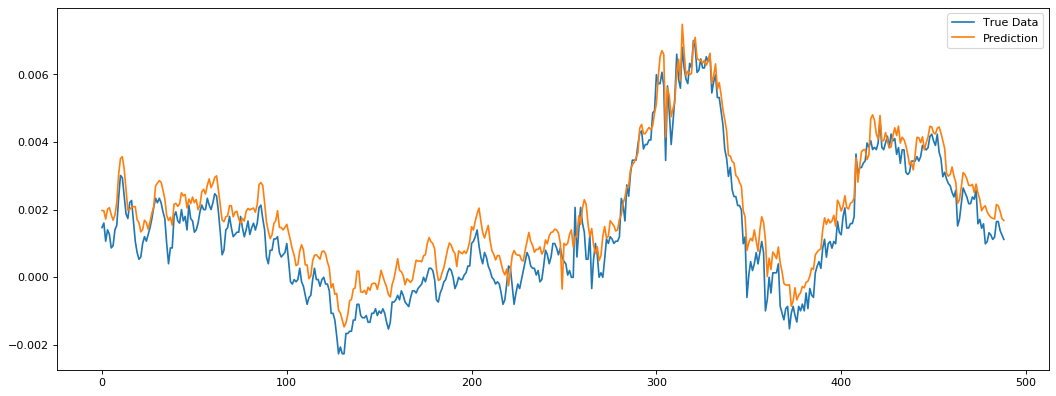

In [9]:
let_us_LSTM(8, 100, True, 50)

[Model] Training Started
[Model] 4 epochs, 50 batch size, 4350 batches per epoch
Epoch 1/4
4350/4350 [==============================] - 730s 168ms/step - loss: 0.8101
Epoch 2/4
4350/4350 [==============================] - 733s 169ms/step - loss: 0.7865
Epoch 3/4
4350/4350 [==============================] - 729s 168ms/step - loss: 0.7708
Epoch 4/4
4350/4350 [==============================] - 725s 167ms/step - loss: 0.7429
[Model] Training Completed. Model saved as saved_models/01122019-083912-e4.h5
Time taken: 0:48:37.102959
[Model] Predicting Sequences Multiple...


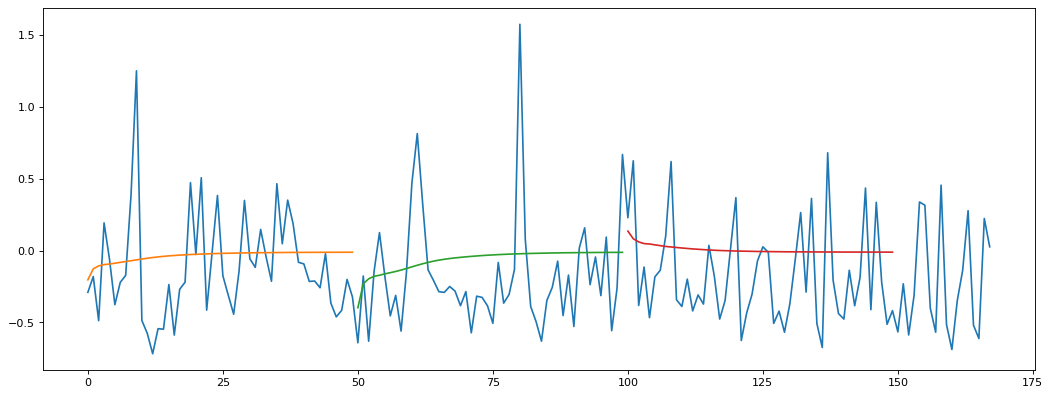

In [14]:
let_us_LSTM_Multiple(4, 50, True, 50)

[Model] Training Started
[Model] 2 epochs, 50 batch size, 4350 batches per epoch
Epoch 1/2
4350/4350 [==============================] - 828s 190ms/step - loss: 0.7315
Epoch 2/2
4350/4350 [==============================] - 978s 225ms/step - loss: 0.7232
[Model] Training Completed. Model saved as saved_models/01122019-145509-e2.h5
Time taken: 0:30:05.493993
[Model] Predicting Sequences Multiple...


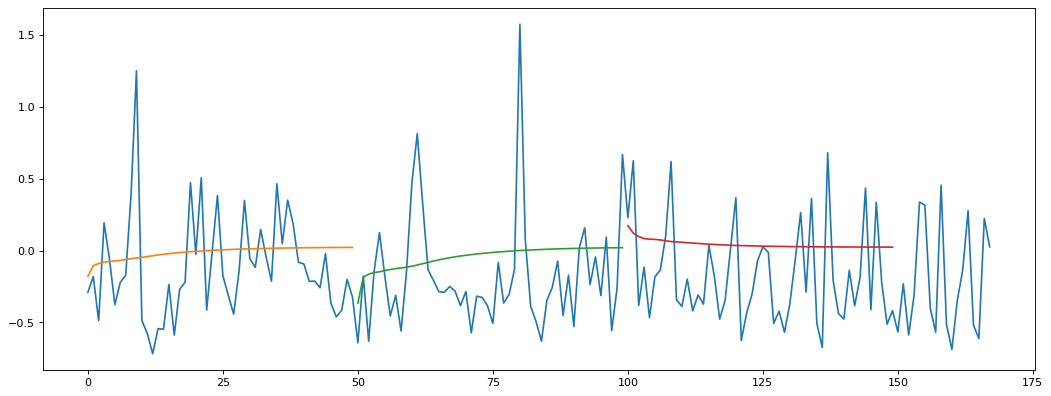

In [15]:
let_us_LSTM_Multiple(2, 50, True, 50)

[Model] Training Started
[Model] 2 epochs, 50 batch size, 113 batches per epoch
Epoch 1/2
113/113 [==============================] - 26s 230ms/step - loss: 0.0016
Epoch 2/2
113/113 [==============================] - 22s 194ms/step - loss: 4.9783e-04
[Model] Training Completed. Model saved as saved_models/02122019-013343-e2.h5
Time taken: 0:00:54.796063
[Model] Predicting Sequences Multiple...


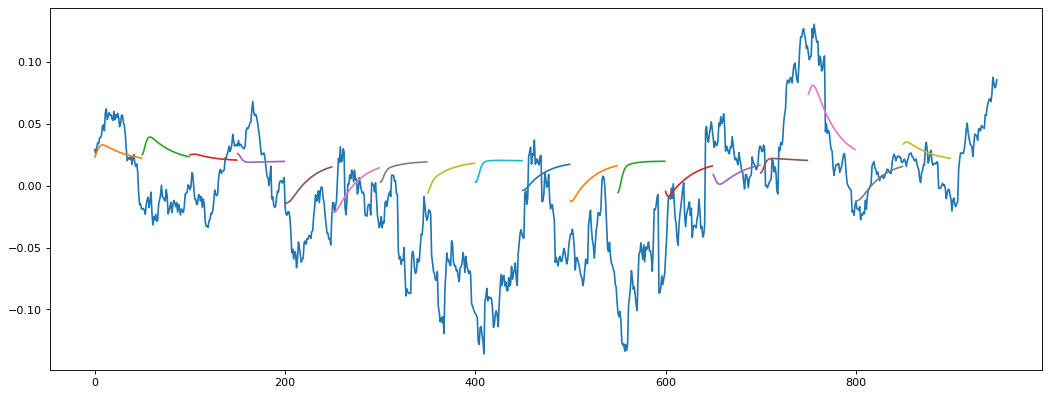

In [42]:
let_us_LSTM_Multiple(2, 50, True, 50)

[Model] Training Started
[Model] 5 epochs, 50 batch size, 113 batches per epoch
Epoch 1/5
113/113 [==============================] - 19s 172ms/step - loss: 3.6087e-04
Epoch 2/5
113/113 [==============================] - 24s 210ms/step - loss: 2.6699e-04
Epoch 3/5
113/113 [==============================] - 22s 195ms/step - loss: 2.0079e-04
Epoch 4/5
113/113 [==============================] - 22s 195ms/step - loss: 1.7904e-04
Epoch 5/5
113/113 [==============================] - 22s 196ms/step - loss: 1.3891e-04
[Model] Training Completed. Model saved as saved_models/02122019-013455-e5.h5
Time taken: 0:01:49.815093
[Model] Predicting Sequences Multiple...


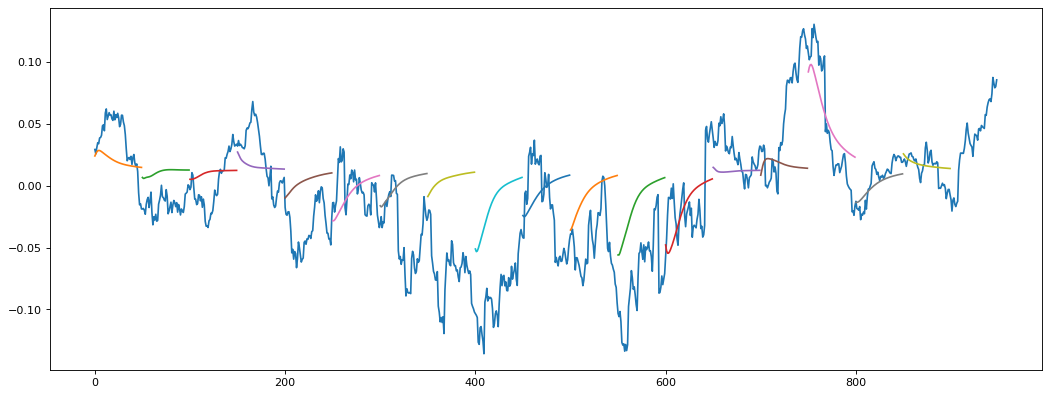

In [43]:
let_us_LSTM_Multiple(5, 50, True, 50)

[Model] Training Started
[Model] 10 epochs, 50 batch size, 113 batches per epoch
Epoch 1/10
113/113 [==============================] - 23s 200ms/step - loss: 0.0017
Epoch 2/10
113/113 [==============================] - 39s 342ms/step - loss: 6.0002e-04
Epoch 3/10
113/113 [==============================] - 48s 429ms/step - loss: 4.1389e-04
Epoch 4/10
113/113 [==============================] - 40s 356ms/step - loss: 2.5939e-04
Epoch 5/10
113/113 [==============================] - 43s 383ms/step - loss: 1.9485e-04
Epoch 6/10
113/113 [==============================] - 35s 307ms/step - loss: 1.8369e-04
Epoch 7/10
113/113 [==============================] - 33s 290ms/step - loss: 1.7317e-04
Epoch 8/10
113/113 [==============================] - 25s 222ms/step - loss: 1.5711e-04
Epoch 9/10
113/113 [==============================] - 24s 210ms/step - loss: 1.1961e-04
Epoch 10/10
113/113 [==============================] - 24s 209ms/step - loss: 1.0110e-04
[Model] Training Completed. Model saved as

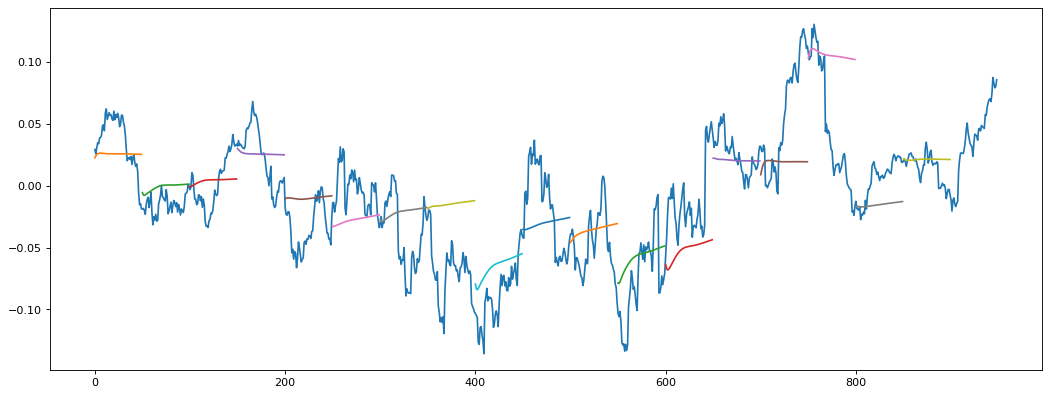

In [46]:
let_us_LSTM_Multiple(10, 50, True, 50)

[Model] Training Started
[Model] 20 epochs, 50 batch size, 113 batches per epoch
Epoch 1/20
113/113 [==============================] - 30s 265ms/step - loss: 9.5398e-05
Epoch 2/20
113/113 [==============================] - 25s 223ms/step - loss: 9.2697e-05
Epoch 3/20
113/113 [==============================] - 26s 231ms/step - loss: 9.1166e-05
Epoch 4/20
113/113 [==============================] - 27s 238ms/step - loss: 8.9082e-05
Epoch 5/20
113/113 [==============================] - 38s 332ms/step - loss: 8.8508e-05
Epoch 6/20
113/113 [==============================] - 24s 210ms/step - loss: 8.7662e-05
Epoch 7/20
113/113 [==============================] - 23s 205ms/step - loss: 7.7456e-05
Epoch 8/20
113/113 [==============================] - 25s 220ms/step - loss: 7.5567e-05
Epoch 9/20
113/113 [==============================] - 29s 259ms/step - loss: 6.9451e-05
Epoch 10/20
113/113 [==============================] - 25s 218ms/step - loss: 7.2136e-05
Epoch 11/20
113/113 [=================

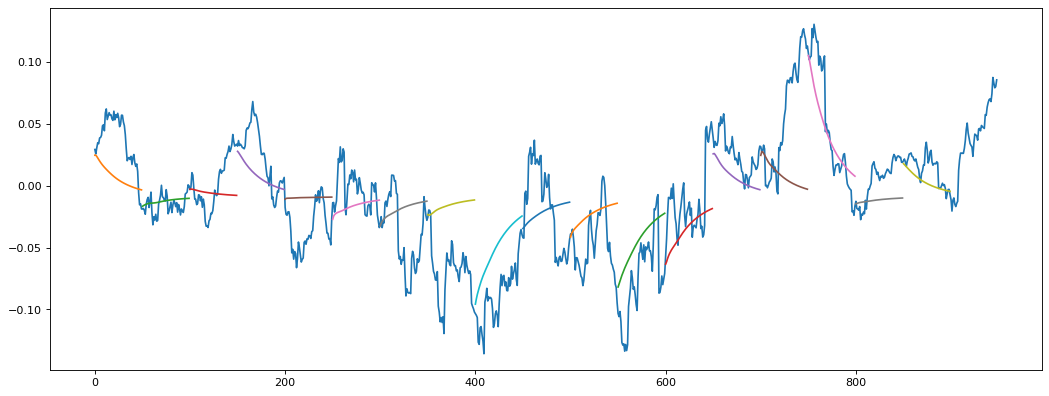

In [47]:
let_us_LSTM_Multiple(20, 50, True, 50)

[Model] Training Started
[Model] 50 epochs, 50 batch size, 113 batches per epoch
Epoch 1/50
113/113 [==============================] - 23s 201ms/step - loss: 7.0105e-05
Epoch 2/50
113/113 [==============================] - 24s 215ms/step - loss: 6.0688e-05
Epoch 3/50
113/113 [==============================] - 28s 250ms/step - loss: 5.1179e-05
Epoch 4/50
113/113 [==============================] - 24s 212ms/step - loss: 5.8716e-05
Epoch 5/50
113/113 [==============================] - 22s 192ms/step - loss: 5.1852e-05
Epoch 6/50
113/113 [==============================] - 27s 242ms/step - loss: 6.6383e-05
Epoch 7/50
113/113 [==============================] - 22s 195ms/step - loss: 6.6042e-05
Epoch 8/50
113/113 [==============================] - 22s 195ms/step - loss: 4.6932e-05
Epoch 9/50
113/113 [==============================] - 24s 214ms/step - loss: 4.5097e-05
Epoch 10/50
113/113 [==============================] - 29s 257ms/step - loss: 5.6111e-05
Epoch 11/50
113/113 [=================

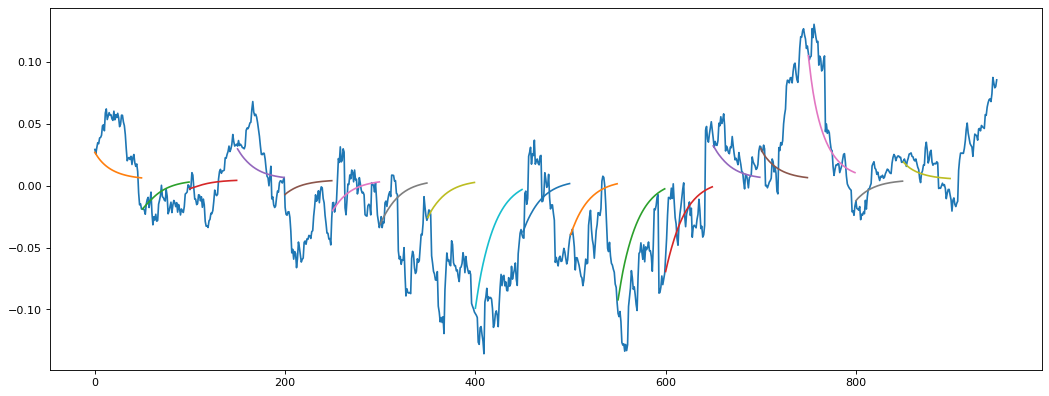

In [48]:
let_us_LSTM_Multiple(50, 50, True, 50)

In [ ]:
let_us_LSTM_Multiple(100, 22, True, 50)

In [2]:
import os
import time
import unicodedata
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pylab import rcParams
from tqdm import tqdm_notebook
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
sns.set(color_codes=True)
import glob
import math

# Get data ready
# Get data ready
# Get data ready (Apple Apple Apple)

In [23]:
path = r'/Users/dior/Documents/GitHub/CSCE_633_Machine_Learning/AAPL_1HOUR_3yu77g/'
all_files = glob.glob(path + "/*.csv")
li = []

index = ["DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME", "NUMBER OF TRADES", "WEIGHTED AV. PRICE"]

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, names=index)
    li.append(df)

apple_hours = pd.concat(li, axis=0, ignore_index=True, sort=False)

In [26]:
apple_hours.shape

(26600, 8)

In [37]:
path = r'/Users/dior/Documents/GitHub/CSCE_633_Machine_Learning/AAPL_1MIN_ct7eed/'
all_files = sorted(glob.glob(path + "/*.csv"))
li = []

index = ["DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME", "NUMBER OF TRADES", "WEIGHTED AV. PRICE"]

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, names=index)
    li.append(df)

apple_minutes = pd.concat(li, axis=0, ignore_index=True, sort=False)

apple_minutes.shape

(1466990, 8)

In [35]:
apple_minutes.to_csv('apple_minutes.csv')

In [2]:
path = r'/Users/dior/Documents/GitHub/CSCE_633_Machine_Learning/Data/Hourly/Apple'
all_files = sorted(glob.glob(path + "/*.csv"))
li = []

index = ["DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME", "NUMBER OF TRADES", "WEIGHTED AV. PRICE"]

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, names=index)
    li.append(df)

apple_hours = pd.concat(li, axis=0, ignore_index=True, sort=False)
 
apple_hours[['DATE','TIME']] = apple_hours.DATETIME.str.split(expand=True)
apple_hours[["YEAR", "MONTH", "DAY"]] = apple_hours.DATE.str.split(".", expand=True)
apple_hours[["HOUR", "MINUTES", "SECONDS"]] = apple_hours.TIME.str.split(":", expand=True)

apple_hours.loc[:, 'DATE'] = pd.to_datetime(apple_hours['DATE'],format='%Y.%m.%d')

apple_hours.to_csv('apple_hours.csv')

NameError: name 'glob' is not defined

# Get data ready
# Get data ready
# Get data ready (Facebook, Facebook, Facebook)

In [3]:
path = r'/Users/dior/Documents/GitHub/CSCE_633_Machine_Learning/Data/Hourly/Amazon'
all_files = sorted(glob.glob(path + "/*.csv"))
li = []

index = ["DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME", "NUMBER OF TRADES", "WEIGHTED AV. PRICE"]

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, names=index)
    li.append(df)

apple_hours = pd.concat(li, axis=0, ignore_index=True, sort=False)
 
apple_hours[['DATE','TIME']] = apple_hours.DATETIME.str.split(expand=True)
apple_hours[["YEAR", "MONTH", "DAY"]] = apple_hours.DATE.str.split(".", expand=True)
apple_hours[["HOUR", "MINUTES", "SECONDS"]] = apple_hours.TIME.str.split(":", expand=True)

apple_hours.loc[:, 'DATE'] = pd.to_datetime(apple_hours['DATE'],format='%Y.%m.%d')

apple_hours.to_csv('data/amazon_hours.csv')

print(1)

1
